<h3><center>Alexandra Almeida</center></h3> 
<h1><center>Project "Green Chillies Prices in India"</center></h1>
<img src="https://upskill.pt/wp-content/uploads/2020/03/cropped-APDC_UPSKILLS_Logo-300x83.png" width="200" align="center">

The present project was carried out under the Machine Learning module as part of the UpsKill program.

I have select a public dataset which contains a time list of chili peppers prices in India over 2048 days. The goal is to forecast prices for next 90 days.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# import excel file and convert into pandas
df = pd.read_csv('Chillies Prices in India.csv', delimiter=';')
df.head()

,datesk,Item Name,Date,price
0,20110101,Chillies Green,01/01/2011,NaN
1,20110101,Chillies Bajji,01/01/2011,NaN
2,20110101,Chillies Cleaned,01/01/2011,NaN
3,20110101,Chillies small (C.B.P),01/01/2011,NaN
4,20110101,Chillies Bajji yagani,01/01/2011,NaN


In [3]:
# check dataframe'shape
df.shape

(13065, 4)

In [4]:
df = df[(df['Item Name']== 'Chillies Green')]
df.shape

(2613, 4)

In [5]:
#drop missing values
df.dropna(inplace=True)

In [6]:
#convert the 'Date' column into a datetime format so that it can interpreted as a date
df['Date'] = pd.to_datetime(df['datesk'], format="%Y%m%d")
df.head()

,datesk,Item Name,Date,price
339,20110309,Chillies Green,2011-03-09,30.0
340,20110310,Chillies Green,2011-03-10,30.0
360,20110314,Chillies Green,2011-03-14,30.0
370,20110316,Chillies Green,2011-03-16,30.0
378,20110317,Chillies Green,2011-03-17,30.0


In [7]:
# remove column 'datesk' and 'Item Name'
df.drop(columns = ['datesk','Item Name'], inplace=True)

In [8]:
# remove rows where price is 0
df = df[~(df['price']== 0)]
df.reset_index(drop=True, inplace=True)
df.shape

(2048, 2)

In [9]:
# get the general descriptive statistics from data
df.describe()

,price
count,2048.000000
mean,35.721191
std,21.060151
min,16.000000
25%,25.000000
50%,30.000000
75%,40.000000
max,598.000000


After cleaning all columns and rows not needed, we can plot the data and visualize the prices evolution. We can see 2 data points where prices were much higher than usual.

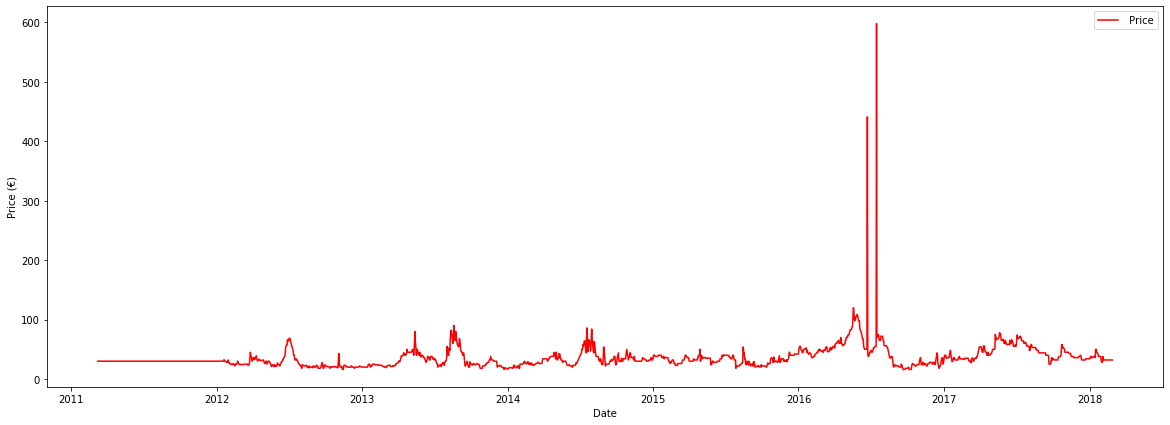

In [10]:
df.sort_values(by=['Date'], ascending = True, inplace = True)

# creating a pot in order to visualize the price evolution.
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['price'].values, label = ' Price', color = 'red')
# plt.xticks(np.arange(100,df.shape[0],100))
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

In [11]:
# sort the dataframe by descending price in order to find the 2 outlier prices
df.sort_values(by=['price'], ascending=False)

,Date,price
1592,2016-07-15,598.0
1574,2016-06-22,441.0
1544,2016-05-18,120.0
1545,2016-05-19,115.0
1551,2016-05-26,108.0
...,...,...
1649,2016-10-07,16.0
1648,2016-10-06,16.0
1638,2016-09-22,16.0
1639,2016-09-24,16.0


In [12]:
#remove prices values 598.0 and 441.0
outliers = df.index[[1574,1592]]
df.drop(outliers, inplace=True)

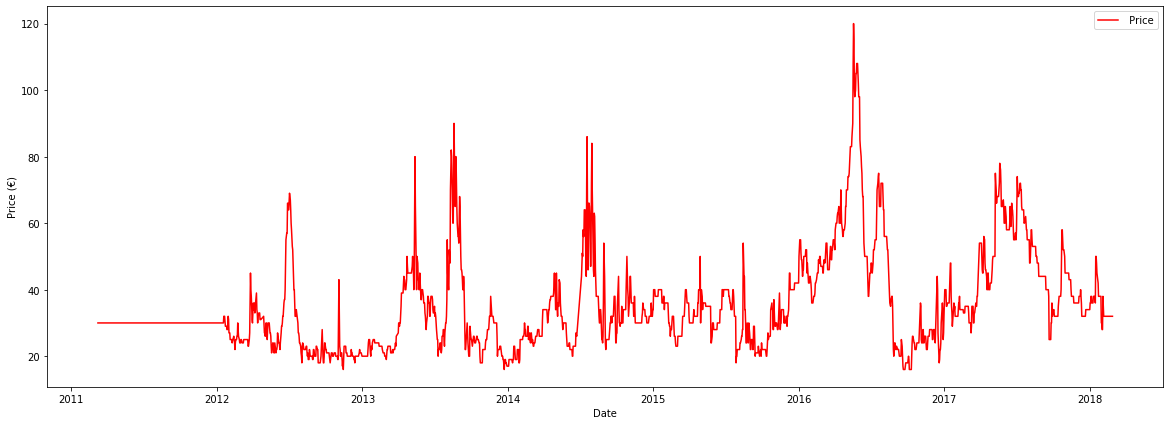

In [13]:
#Create a new plot without ouliers
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['price'].values, label = ' Price', color = 'red')
# plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

## LSTM

In [14]:
# reserve 80% of the number of records for training
num_records = round(len(df)*0.8)
train = df.iloc[:num_records, 1:2].values
test = df.iloc[num_records:, 1:2].values

Scaling features using normalization. 

In [15]:
# Normalize the data using MinMax method
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_scaled = sc.fit_transform(train)

Now we take one row and cut it with a window of 90 elements

In [16]:
X_train = []

#Price on next day
y_train = []

window = 90

for i in range(window, num_records):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

Training the model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import *

# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 90, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [18]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train, y_train, epochs = 100, batch_size = 512);

Epoch 1/100
4/4 [==============================] - 9s 718ms/step - loss: 0.0384
Epoch 2/100
4/4 [==============================] - 3s 675ms/step - loss: 0.0169
Epoch 3/100
4/4 [==============================] - 3s 735ms/step - loss: 0.0151
Epoch 4/100
4/4 [==============================] - 4s 805ms/step - loss: 0.0140
Epoch 5/100
4/4 [==============================] - 3s 760ms/step - loss: 0.0119
Epoch 6/100
4/4 [==============================] - 3s 745ms/step - loss: 0.0111
Epoch 7/100
4/4 [==============================] - 3s 794ms/step - loss: 0.0098
Epoch 8/100
4/4 [==============================] - 4s 844ms/step - loss: 0.0091
Epoch 9/100
4/4 [==============================] - 4s 812ms/step - loss: 0.0088
Epoch 10/100
4/4 [==============================] - 3s 755ms/step - loss: 0.0086
Epoch 11/100
4/4 [==============================] - 4s 783ms/step - loss: 0.0077
Epoch 12/100
4/4 [==============================] - 4s 826ms/step - loss: 0.0076
Epoch 13/100
4/4 [===================

## Prediction

In [19]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_records + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [20]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)
len(predict)

409

In [21]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 30.786817386104744
MAE: 3.9033393160346668
RMSE: 5.5485869720231245


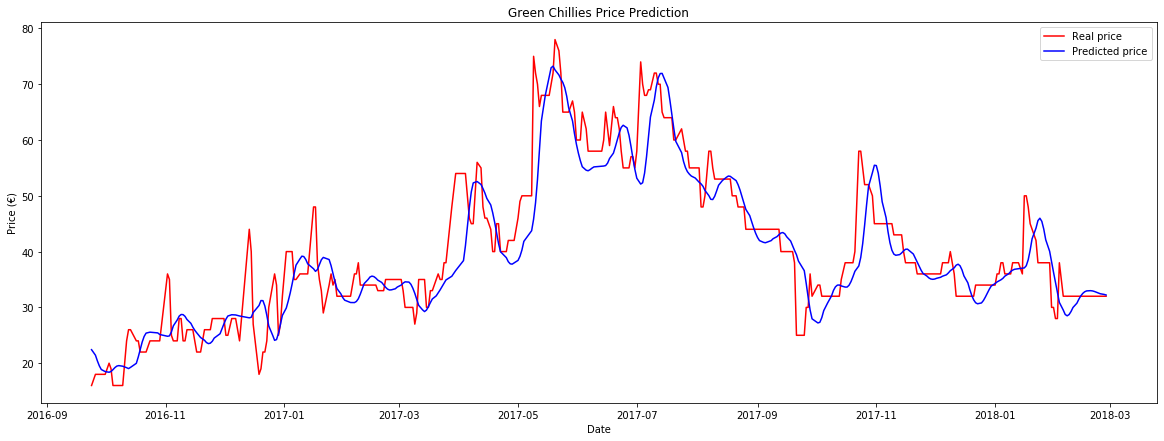

In [22]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted price')
# plt.xticks(np.arange(0,df[1800:].shape[0],25), rotation=45)
plt.title('Green Chillies Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

## 90-day prediction

In [23]:
pred_ = predict[-1].copy()
prediction_full = []
window = 90
df_copy = df.iloc[:, 1:2][1:].values

for j in range(90):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_records]
    test_ = df_[num_records:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

len(prediction_full)

90

In [24]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

len(prediction_full_new)

499

In [25]:
df_date = df[['Date']]

for h in range(90):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)
len(df_date)

2136

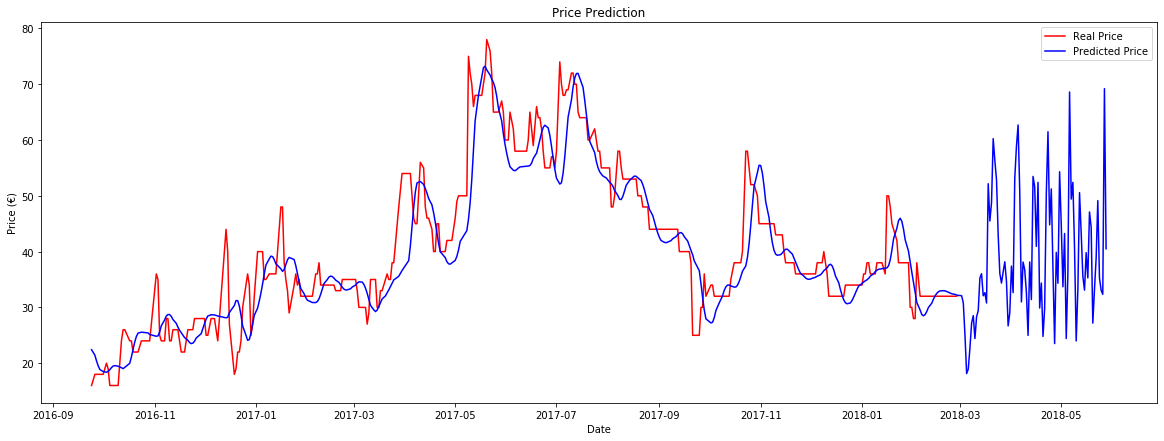

In [26]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,df_date[1800:].shape[0],25), rotation=45)
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

## GRU

In [27]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 90, 50)            7950      
_________________________________________________________________
dropout_4 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 90, 50)            15300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 90, 50)            15300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)               

In [28]:
modelGRU.compile(optimizer='adam', loss='mse')
modelGRU.fit(X_train, y_train, epochs=100, batch_size=512)

Epoch 1/100
4/4 [==============================] - 10s 869ms/step - loss: 0.0337
Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 0.0133
Epoch 3/100
4/4 [==============================] - 4s 930ms/step - loss: 0.0090
Epoch 4/100
4/4 [==============================] - 4s 968ms/step - loss: 0.0090
Epoch 5/100
4/4 [==============================] - 3s 767ms/step - loss: 0.0061
Epoch 6/100
4/4 [==============================] - 4s 846ms/step - loss: 0.0061
Epoch 7/100
4/4 [==============================] - 4s 835ms/step - loss: 0.0050
Epoch 8/100
4/4 [==============================] - 3s 776ms/step - loss: 0.0056
Epoch 9/100
4/4 [==============================] - 4s 801ms/step - loss: 0.0047
Epoch 10/100
4/4 [==============================] - 4s 794ms/step - loss: 0.0046
Epoch 11/100
4/4 [==============================] - 4s 852ms/step - loss: 0.0049
Epoch 12/100
4/4 [==============================] - 4s 824ms/step - loss: 0.0040
Epoch 13/100
4/4 [=====================

In [29]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [30]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 19.67387233327649
MAE: 2.8245319235878643
RMSE: 4.435523907417982


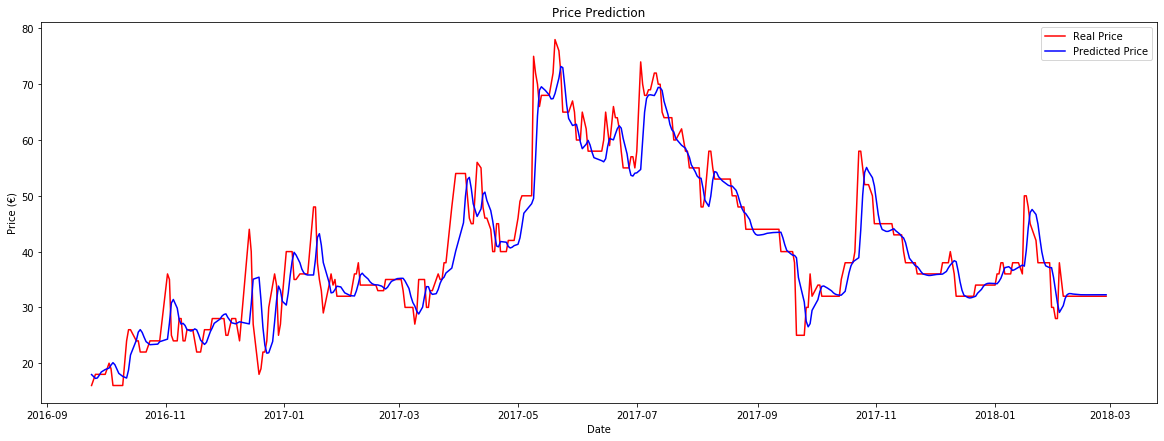

In [33]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,df[num_records:].shape[0],25), rotation=45)
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

## 90-day prediction

In [34]:
pred_ = predict[-1].copy()
prediction_full = []
window = 90
df_copy = df.iloc[:, 1:2][1:].values

for j in range(90):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_records]
    test_ = df_[num_records:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [35]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(90):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

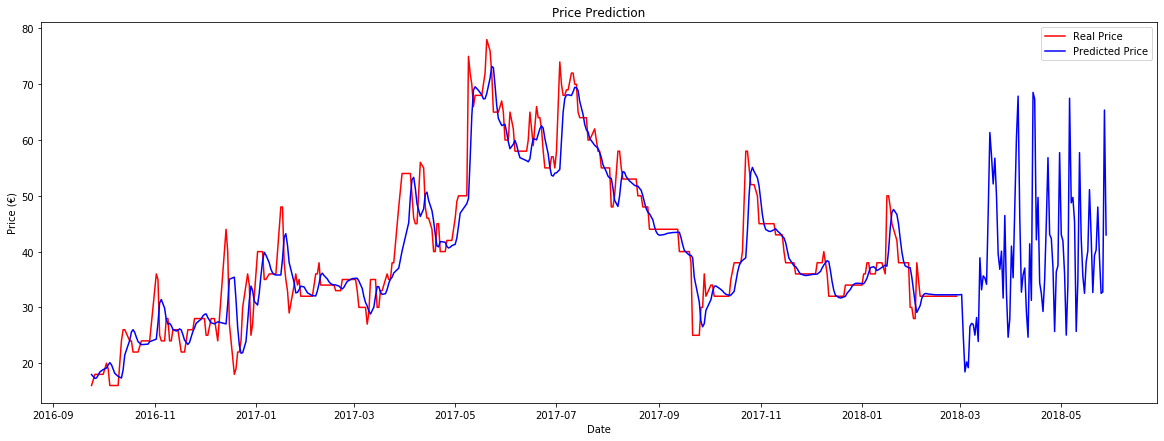

In [36]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,df_date[1800:].shape[0],25), rotation=45)
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()